In [313]:
#read data and declare libraries
import pandas 
import matplotlib.pyplot as plt
import numpy
from sklearn.linear_model import LinearRegression

#url where data came from - it does update; so be warned your milage may vary 
#https://data.cityofnewyork.us/City-Government/DSNY-Monthly-Tonnage-Data/ebb7-mvp5

df = pandas.read_csv('DSNY_Monthly_Tonnage_Data.csv')# no path needed as it is loaded into my jupiter notebook folder 

Main inquiry: Has Garbage increased over time.
Sub-inquiry: Have indvidual boroughs increaesed garbage over time.
Sub-inquiry: Are holidays or warm weather driving trends in trash.
Sub-inquiry: Is recycling changing significantly with trends in garbage?  i.e. as less garbage is being trashed is there more recycling? 


https://github.com/ATruckingTurtle/Project1.git

In [314]:
'''Data exam section'''
print("Data frame before removing rows.")
print(df.shape)
#starts out with 23178 rows by 11 columns.
#print(df.isnull().sum())
'''Per the dataset it seems like there is not much missing data
with the exception of recycling and split by organization.'''
df.drop_duplicates(keep='last', inplace = False, ignore_index =False)#drop duplicates
#went with last, just incase a value was entered twice the second is more likly the correct entry.

df['MONTH'] = pandas.to_datetime(df['MONTH'],format= 'mixed') #changing Month to datetime for later use.
df = df.rename(columns ={"MONTH":"Date","BOROUGH":"Borough","REFUSETONSCOLLECTED":"Garbage(Tons)"}) #re-naming columns
df = df.rename(columns ={"PAPERTONSCOLLECTED":"Paper_Recycling","MGPTONSCOLLECTED":"Mixed_Recycling","XMASTREETONS":"XMAS_Trees_2_Muluch"})

'''I do not know if trash is picked up the first of the month in New York, but now it is in my data.
so at frist dates are object type YYYY/MM however after this little operation it is datetime64,
and formated MM/01/YYYY at least visually'''

#print('object types')
print('\n')
print(df.dtypes)

#df.head(4)



Data frame before removing rows.
(23178, 11)


Date                   datetime64[ns]
Borough                        object
COMMUNITYDISTRICT              object
Garbage(Tons)                 float64
Paper_Recycling               float64
Mixed_Recycling               float64
RESORGANICSTONS               float64
SCHOOLORGANICTONS             float64
LEAVESORGANICTONS             float64
XMAS_Trees_2_Muluch           float64
BOROUGH_ID                    float64
dtype: object


In [315]:
"""Dropping a few columns, and selecting values since 1999"""
remove_columns = ['RESORGANICSTONS','SCHOOLORGANICTONS','LEAVESORGANICTONS','BOROUGH_ID','COMMUNITYDISTRICT'] 
df.drop(remove_columns,inplace=True, axis =1) #hanging onto the remaining columns for the time being.
#print(df.dtypes)

df = df.sort_values(by = ['Date','Borough'], ascending = True) #Sorts by time then Borough.
#print('before', df.shape)
df.drop(df[df['Date']<'1999/ 01'].index, inplace = True) #not entirly certain why this works still, format changed.
df.drop(df[df['Date']>='2023/ 01'].index, inplace = True) #seemed better to remove partly year.

print(df.isnull().sum())
print ('I am not too worried about the missing values in recycling. This could be filled with zeros, but I think it is fine this way.')
print('\n')
print('Data frame after removing values before 01/1999 and date after 12/2022.')
print(df.shape)
print('\n\n')
print(df.head(3))

df = df.sort_values(by = ['Date','Borough'], ascending = False) #returning format newest data on top.

Date                       0
Borough                    0
Garbage(Tons)              6
Paper_Recycling          761
Mixed_Recycling         1232
XMAS_Trees_2_Muluch    15667
dtype: int64
Data frame after removing values before 01/1999 and date after 12/2022.
(16998, 6)



            Date Borough  Garbage(Tons)  Paper_Recycling  Mixed_Recycling  \
11692 1999-01-01   Bronx         1840.0             77.4            132.2   
12499 1999-01-01   Bronx         3369.5            457.1            559.9   
13499 1999-01-01   Bronx         1273.7             63.7            131.8   

       XMAS_Trees_2_Muluch  
11692                  5.2  
12499                 25.1  
13499                  3.9  


This data looked pretty consistent.  I am taking a risk in not looking for outliars as I would not entirely know to fill it with.
the only logical thing to fill it with would be an average of its neighboring values.  I think garbage/ recycling are volatile data
by nature, so many things affect if we remeber to get the recycling sorted and borught down, or the garbage bin is not in the right 
spot. I really should have taken a look for garbage strikes and tried to leave that out, but at the end of the day once the strike is 
over the garabage is still processed so it would really just be an isolated one month anomoly, but the following month would have the
sum of both.

In [316]:
'''Pivot table of boroughs'''
#print(df.dtypes)
#reduce 'Communites' to shared borough - use pivot table


table = numpy.round(pandas.pivot_table(df, values = ['Garbage(Tons)',"Paper_Recycling","Mixed_Recycling",'XMAS_Trees_2_Muluch'], index = ['Borough'],
                           aggfunc={'Garbage(Tons)':'mean',"Paper_Recycling":'mean',"Mixed_Recycling":'mean','XMAS_Trees_2_Muluch':'mean'}),2)

print('Average for disposal by borough for the past 24 years.\n')
display(table) #does not always display without display()


Average for disposal by borough for the past 24 years.



,Garbage(Tons),Mixed_Recycling,Paper_Recycling,XMAS_Trees_2_Muluch
Borough,,,,
Bronx,2979.66,262.59,224.87,13.32
Brooklyn,3852.55,352.84,423.49,20.35
Manhattan,3159.40,342.43,478.72,36.19
Queens,4363.81,467.63,540.40,30.69
Staten Island,5338.37,591.26,746.83,63.19


The pivot table above averages the values for garbage, mixed recycling, paper recycling, and Xmas tree recycling. 
I have attached an image from wikipedia summazing the 2020 census for new york. My inital hunch was that areas with higher population would have greater amounts of garbage and recycling.  However that trend does not seem to stand. New York is a very active place with a lot of people coming into the city, so population does not nessicaly reflect how many people are in an area.  It almost seems like their is an inverse relationship where lower population leads to more garabage and recycling.  Also I find it amazing that Staten Island has averaged 63 tons of Xmas trees for 24 years.  I googled it and the average tree weighs about 50 pounds.

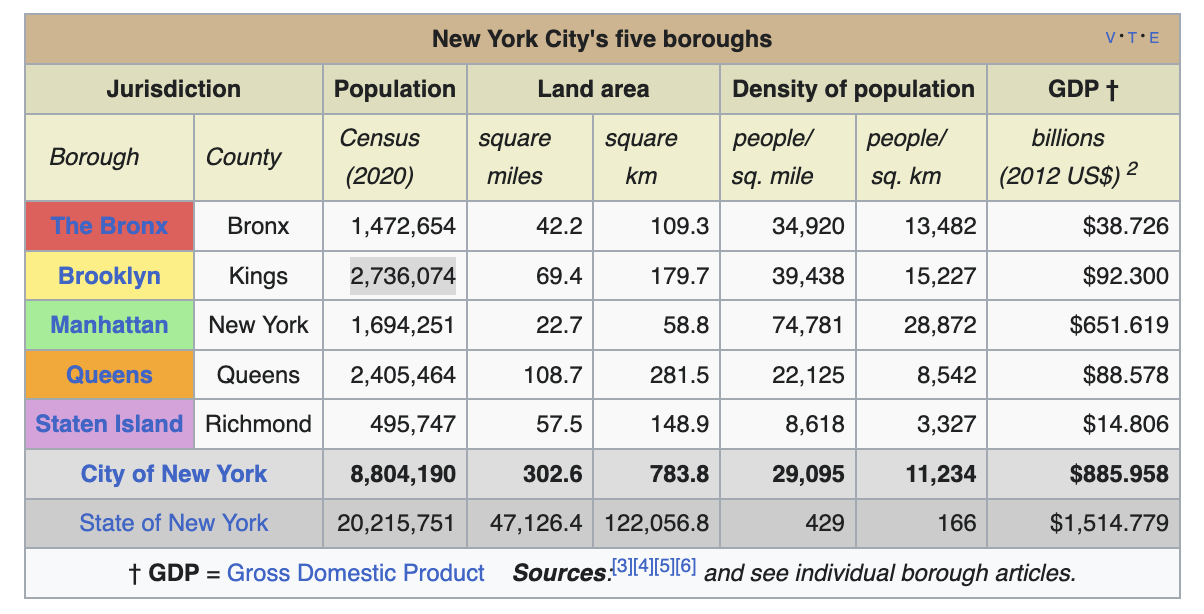

In [317]:
'''Sum by month when using pivot table'''
df_Single_Year = df.copy()

single_year = '2016' # faster to change this way

df_Single_Year.drop(df_Single_Year[df_Single_Year['Date']<single_year+'/ 01'].index, inplace = True) #drops everything younger than single year
df_Single_Year.drop(df_Single_Year[df_Single_Year['Date']>single_year+'/ 12'].index, inplace = True) #drops evrything greater than single year date.

#print(df_Single_year_2015.head(12))
table = numpy.round(pandas.pivot_table(df_Single_Year, values = ['Garbage(Tons)',"Paper_Recycling","Mixed_Recycling",'XMAS_Trees_2_Muluch'], index = ['Date'],
                           aggfunc={'Garbage(Tons)':'sum'}, columns = ['Borough']),2) 
display(table) #does not always display without display()


Garbage(Tons)                                          
Borough            Bronx Brooklyn Manhattan   Queens Staten Island
Date                                                              
2016-01-01       30764.3  59938.6   32863.4  49282.2       12060.1
2016-02-01       30874.1  59921.6   32680.7  49581.1       11977.2
2016-03-01       33927.7  67324.6   35283.9  56820.8       14128.9
2016-04-01       32663.5  65870.4   34381.2  56588.5       14567.0
2016-05-01       33874.7  68138.0   34981.4  61297.3       16078.4
2016-06-01       36932.6  73879.6   37290.2  65695.0       17148.7
2016-07-01       34745.6  66641.8   33287.9  61867.4       15349.1
2016-08-01       36132.6  68773.6   35221.3  64120.1       15725.7
2016-09-01       33925.5  67291.8   35165.2  59685.4       14496.1
2016-10-01       33838.2  67430.9   35566.4  58291.9       14458.3
2016-11-01       35119.3  67958.7   35972.6  58682.0       15374.5
2016-12-01       35003.9  68165.4   36145.7  57052.8       14716.7

Using a single year from 2016 to vizualize the trend in disposal.  It would seem there is a surge in the summer
as well as a smaller surge in December.  I think the larger surge is due to more people getting out in good weather, 
and taking on more projects. As well as more visitors coming to the city.  The winter surge is likly due to an
uptick in shopping and gatherings related to holidays.


Using a single year from 2016 to vizualize the trend in disposal.  It would seem there is a surge in the summer
as well as a smaller surge in December.  I think the larger surge is due to more people getting out in good weather, and taking on more projects. As well as more visitors coming to the city.  The winter surge is likly due to an uptick in shopping and gatherings related to holidays.

I tested it with a few different years and on occasion May has the highest level of garbage generation, but I suspect that it is driven by the first occurance of nice contious weather, which must in general be June.

Text(0.5, 1.0, 'Bronx Refuse')

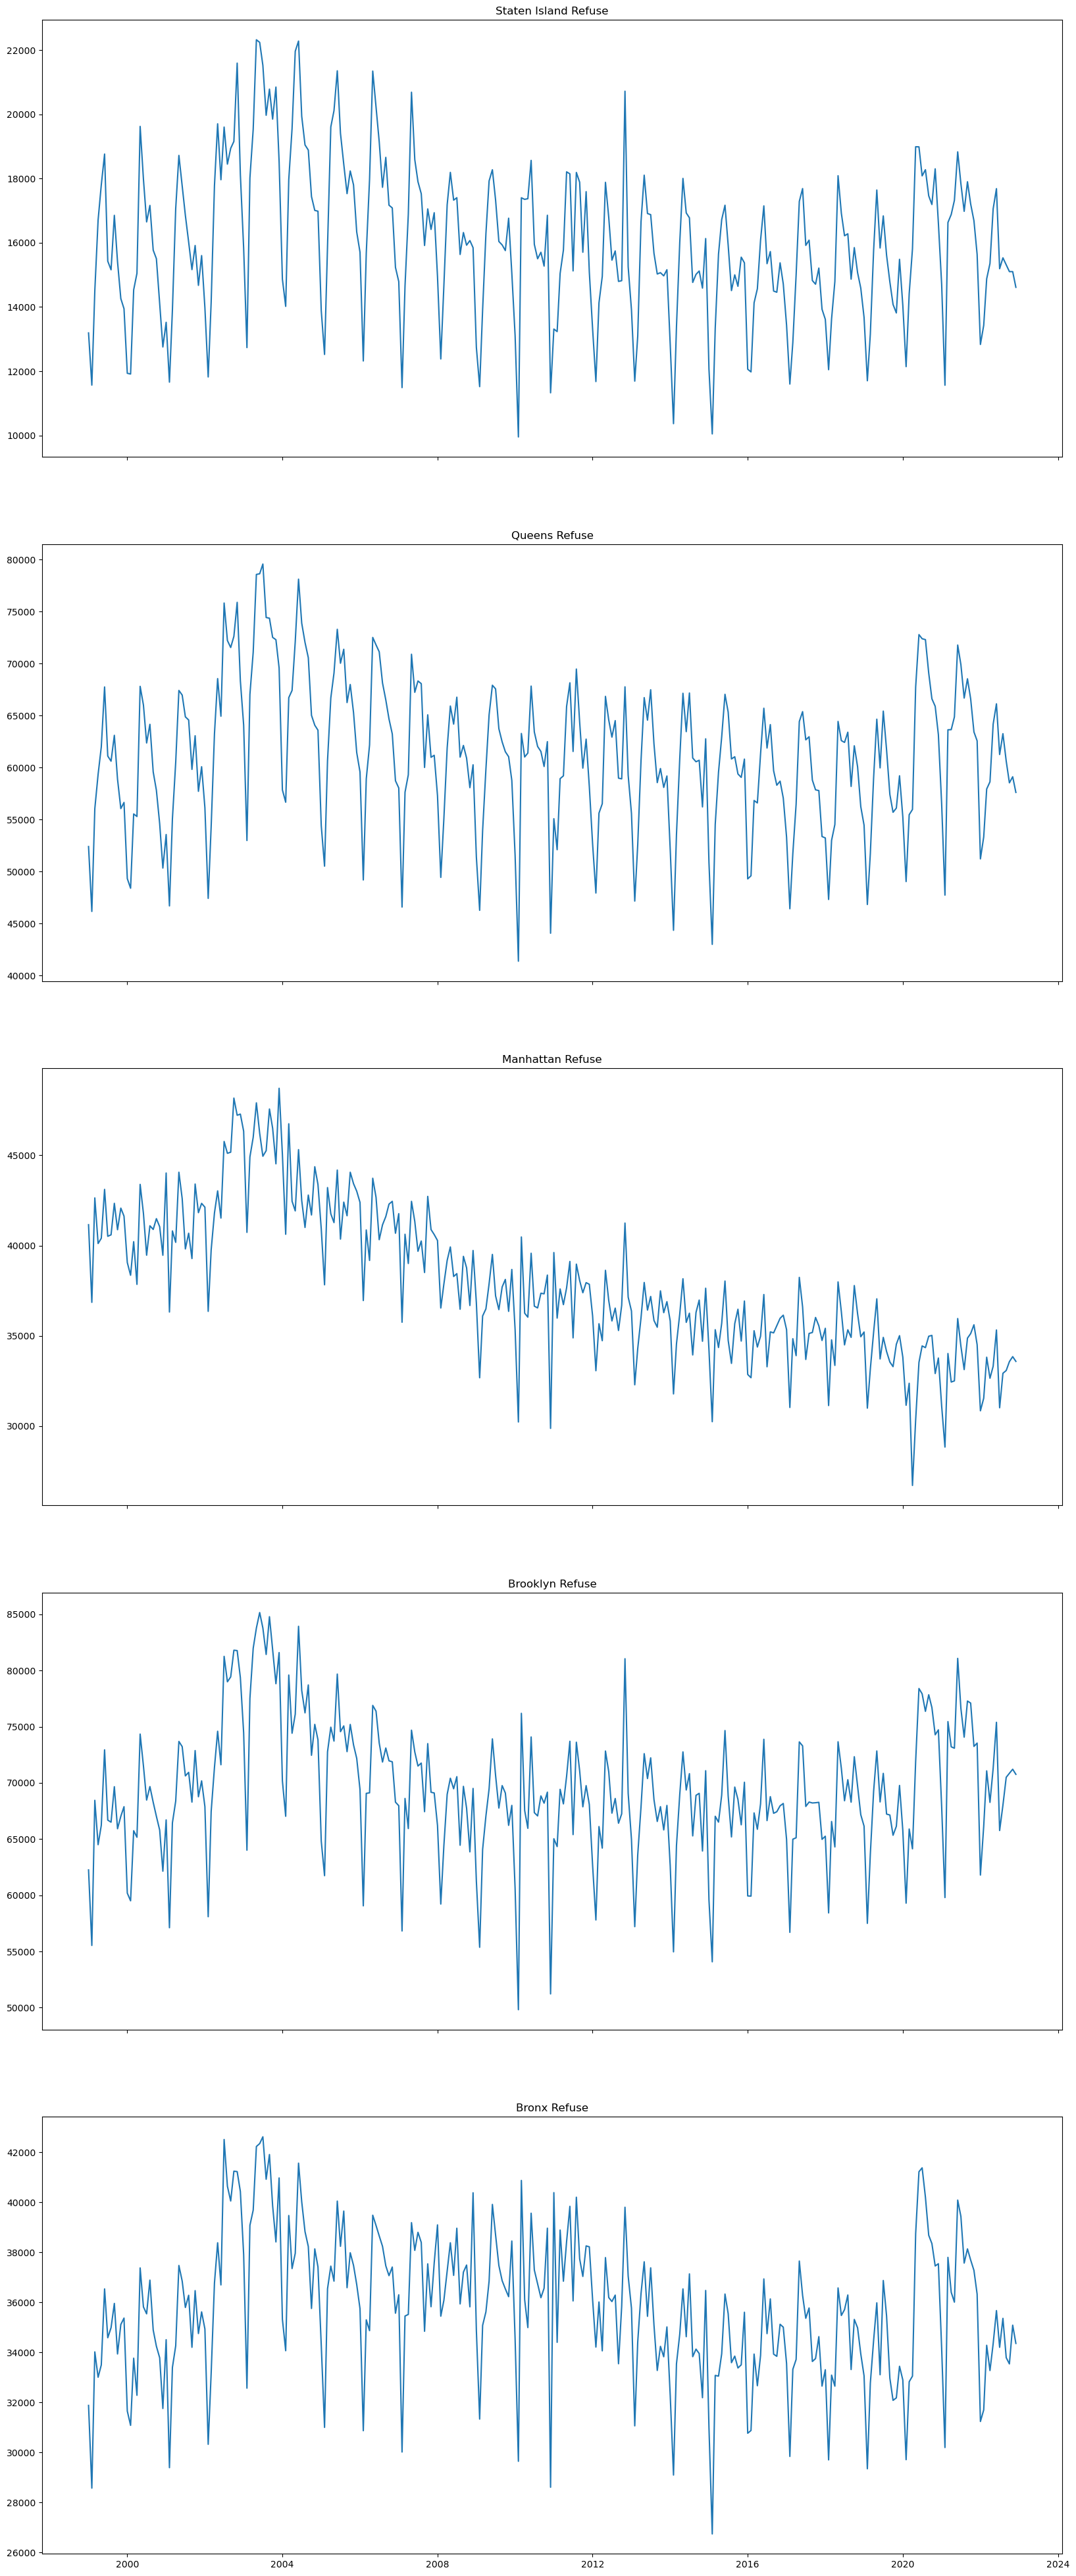

In [318]:
'''Line Charts'''

#seperating out boroughs
df_Staten_Island = df.loc[df['Borough'] == 'Staten Island']
df_Queens = df.loc[df['Borough'] == 'Queens']
df_Manhattan = df.loc[df['Borough'] == 'Manhattan']
df_Brooklyn = df.loc[df['Borough'] == 'Brooklyn']
df_Bronx = df.loc[df['Borough'] == 'Bronx']

#grouping items based on date.  So this removes communities and leaves one entry per borough.
grouper = {'Date':'first','Garbage(Tons)':'sum','Paper_Recycling':'sum','Mixed_Recycling':'sum','XMAS_Trees_2_Muluch':'sum'}
df_Staten_Island_Sum = df_Staten_Island.groupby(df_Staten_Island['Date']).aggregate(grouper)
df_Queens_Sum = df_Queens.groupby(df_Queens['Date']).aggregate(grouper)
df_Manhattan_Sum = df_Manhattan.groupby(df_Manhattan['Date']).aggregate(grouper)
df_Brooklyn_Sum = df_Brooklyn.groupby(df_Brooklyn['Date']).aggregate(grouper)
df_Bronx_Sum = df_Bronx.groupby(df_Bronx['Date']).aggregate(grouper)

#print (df_Staten_Island.iloc[:,2])

#model = LinearRegression()
#x = df_Staten_Island.iloc[:,0]
#y = df_Staten_Island.iloc[:,2]
#model.fit(X=x.values.reshape(-1, 1), y = y) 
#y_model_values = model.predict(x.values.reshape(-1, 1))
#display(df_Staten_Island_Sum.corr())

#Shows the various recycling results for several areas.
fig, axes = plt.subplots(5,1,sharex = True, figsize =(20,50))
axes[0].plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Garbage(Tons)'])
#axes[0].plot(df_Staten_Island_Sum['Date'],y_model_values)
axes[0].set_title('Staten Island Refuse')

axes[1].plot(df_Queens_Sum['Date'],df_Queens_Sum['Garbage(Tons)'])
axes[1].set_title('Queens Refuse')

axes[2].plot(df_Manhattan_Sum['Date'],df_Manhattan_Sum['Garbage(Tons)'])
axes[2].set_title('Manhattan Refuse')

axes[3].plot(df_Brooklyn_Sum['Date'],df_Brooklyn_Sum['Garbage(Tons)'])
axes[3].set_title('Brooklyn Refuse')

axes[4].plot(df_Bronx_Sum['Date'],df_Bronx_Sum['Garbage(Tons)'])
axes[4].set_title('Bronx Refuse')


I do wish I was able to generate a trendline, but I couldn't think how to do with datetime.  Maybe I could have done len(y) in an array I am really not sure about that.  Just from observing the charts though I think there is a strong argument that garabage is trending down.  With the strongest trends being Staten Island and Manhatten. Brooklyn I would argue is the only one tha tis coming up slightly. The valleys appear to correlate to poorer weather with the excption of the holiday season, and the high points correlate to warmer weather at least from what I could determine.

Text(0.5, 1.0, 'Bronx Mixed Recycling')

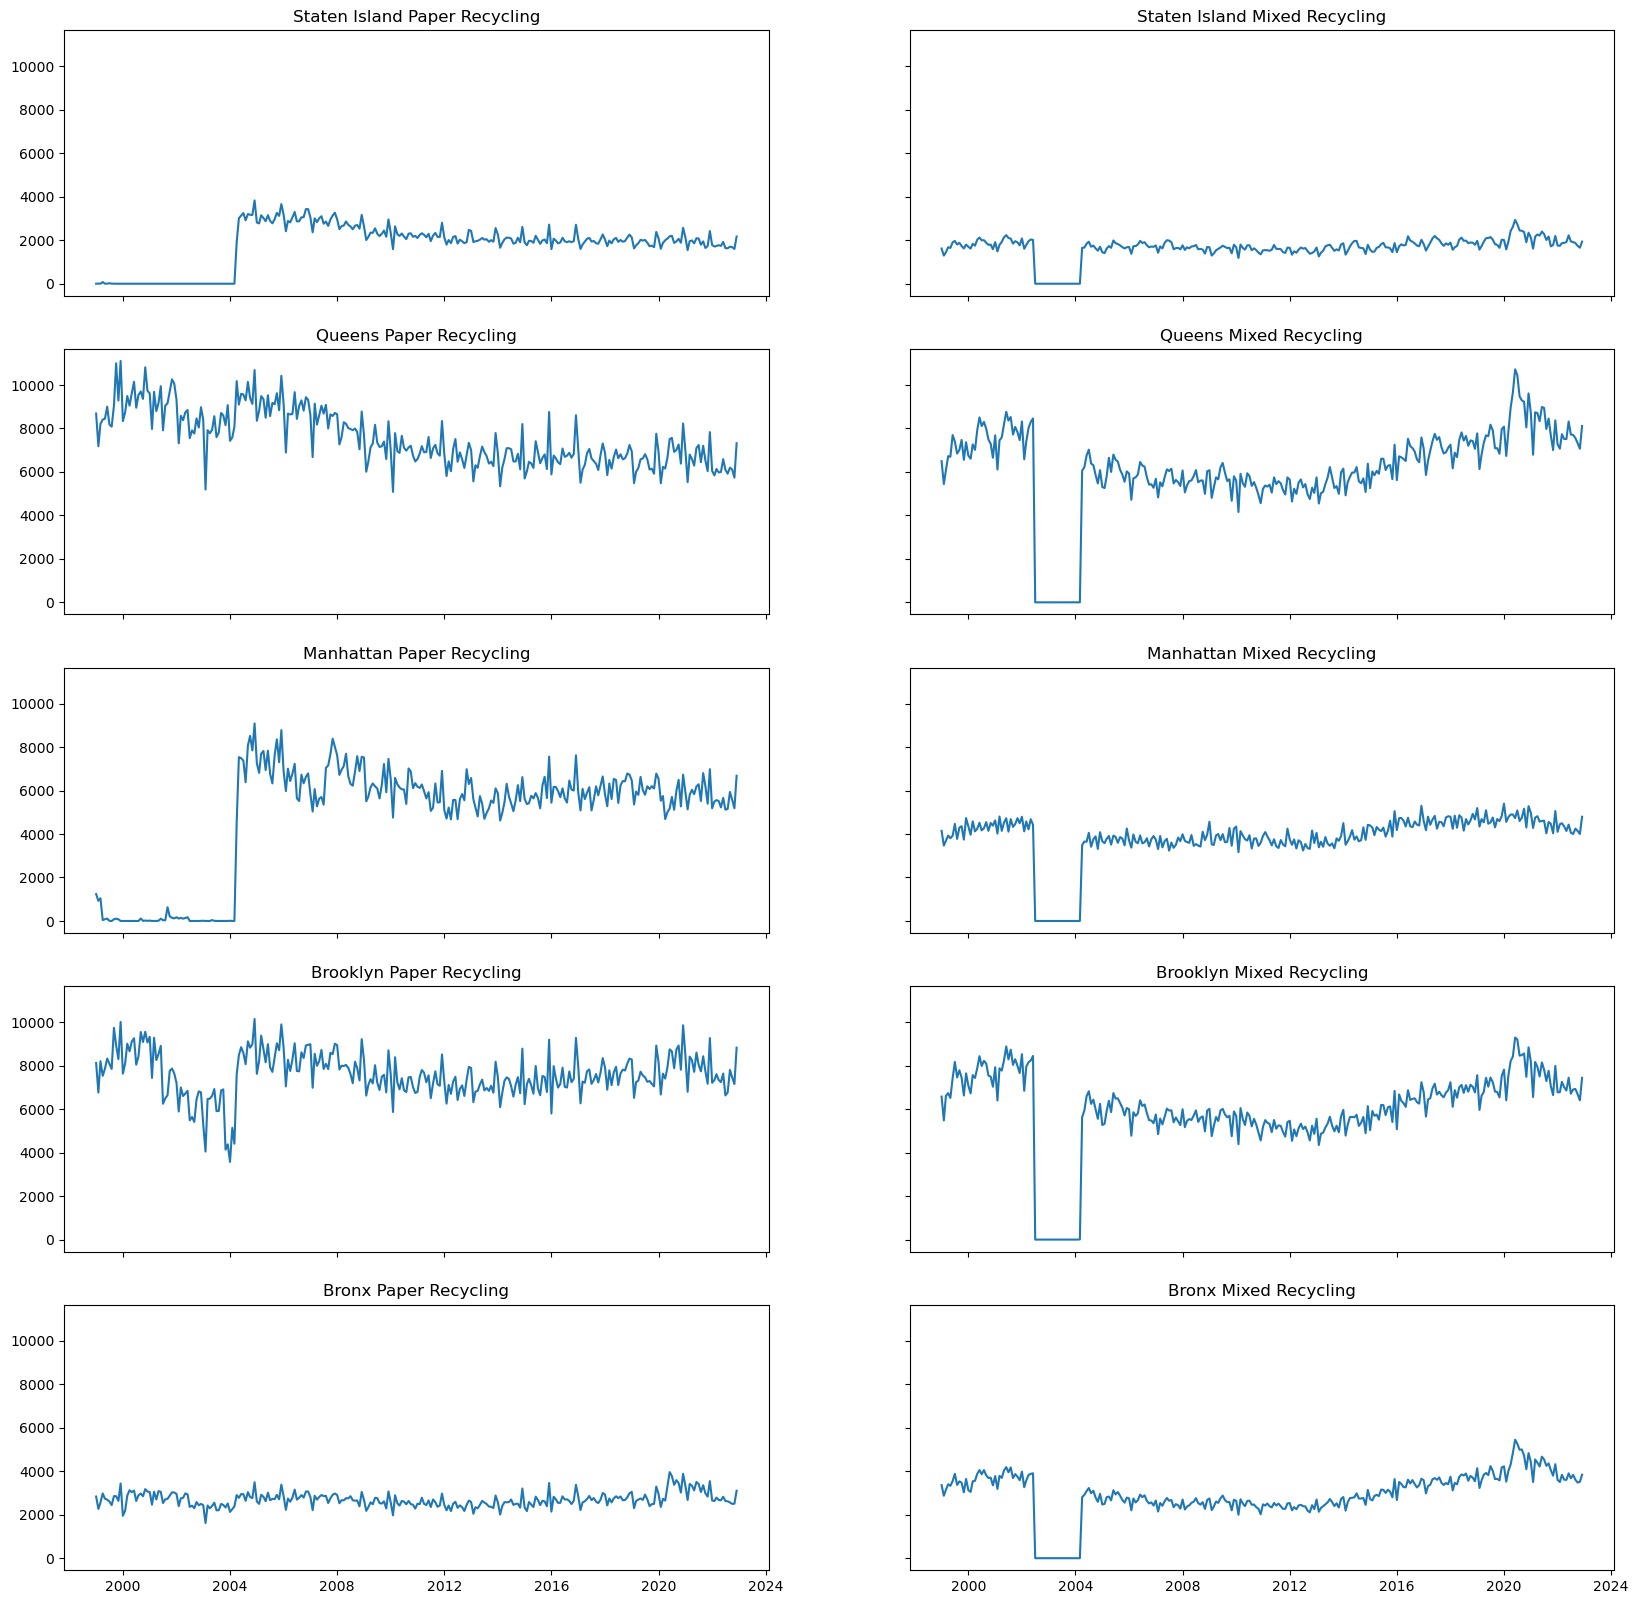

In [319]:
#Shows the various recycling results for several areas.
fig, axes = plt.subplots(5,2,sharex = True, sharey = True, figsize =(20,20))
axes[0,0].plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Paper_Recycling'])
axes[0,1].plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Mixed_Recycling'])
axes[0,0].set_title('Staten Island Paper Recycling')
axes[0,1].set_title('Staten Island Mixed Recycling')

axes[1,0].plot(df_Queens_Sum['Date'],df_Queens_Sum['Paper_Recycling'])
axes[1,1].plot(df_Queens_Sum['Date'],df_Queens_Sum['Mixed_Recycling'])
axes[1,0].set_title('Queens Paper Recycling')
axes[1,1].set_title('Queens Mixed Recycling')

axes[2,0].plot(df_Manhattan_Sum['Date'],df_Manhattan_Sum['Paper_Recycling'])
axes[2,1].plot(df_Manhattan_Sum['Date'],df_Manhattan_Sum['Mixed_Recycling'])
axes[2,0].set_title('Manhattan Paper Recycling')
axes[2,1].set_title('Manhattan Mixed Recycling')

axes[3,0].plot(df_Brooklyn_Sum['Date'],df_Brooklyn_Sum['Paper_Recycling'])
axes[3,1].plot(df_Brooklyn_Sum['Date'],df_Brooklyn_Sum['Mixed_Recycling'])
axes[3,0].set_title('Brooklyn Paper Recycling')
axes[3,1].set_title('Brooklyn Mixed Recycling')

axes[4,0].plot(df_Bronx_Sum['Date'],df_Bronx_Sum['Paper_Recycling'])
axes[4,1].plot(df_Bronx_Sum['Date'],df_Bronx_Sum['Mixed_Recycling'])
axes[4,0].set_title('Bronx Paper Recycling')
axes[4,1].set_title('Bronx Mixed Recycling')

#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Garbage(Tons)'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Paper_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Mixed_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['XMAS_Trees_2_Muluch'])

#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Garbage(Tons)'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Paper_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Mixed_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['XMAS_Trees_2_Muluch'])

#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Garbage(Tons)'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Paper_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Mixed_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['XMAS_Trees_2_Muluch'])

#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Garbage(Tons)'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Paper_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Mixed_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['XMAS_Trees_2_Muluch'])

#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Garbage(Tons)'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Paper_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['Mixed_Recycling'])
#plt.plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['XMAS_Trees_2_Muluch'])

I wanted to see how paper recycling and mixed recycling are trending.  From what I could determine paper is being recycled largely the same over the 23 year period. I suspect fewer people are buying news papers so I am not certain why it stayed up so high.  The mixed recycling is on an upward trend.  That low spot on all the graphs is from budget issues as a result of 9/11.  Mixed recycling is a mixture of glass, metal, and plastic.

'It seems as though paper recycling follows a different trend.  \nIt seems like the amount recycled goes up in the winter, with a small spike during the start of summer.'

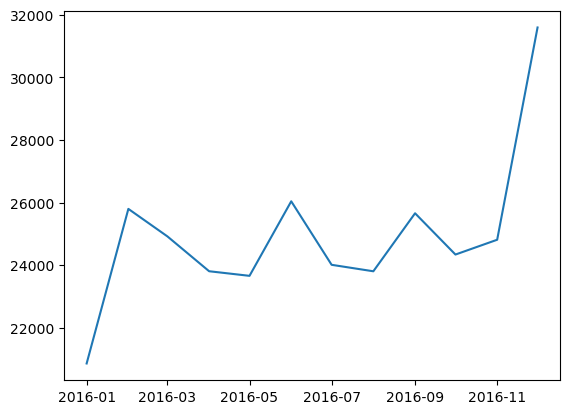

In [320]:
#applying grouper to single year.
df_Single_Year = df_Single_Year.groupby(df_Single_Year['Date']).aggregate(grouper)

plt.plot(df_Single_Year['Date'],df_Single_Year['Paper_Recycling'])

It seems as though paper recycling follows a different trend.  
It seems like the amount recycled goes up in the winter, with a small spike during the start of summer.
this chart is based on paper recycliing for a single year in 2016.

Text(0.5, 1.0, 'Bronx XMAS Tree Muluching')

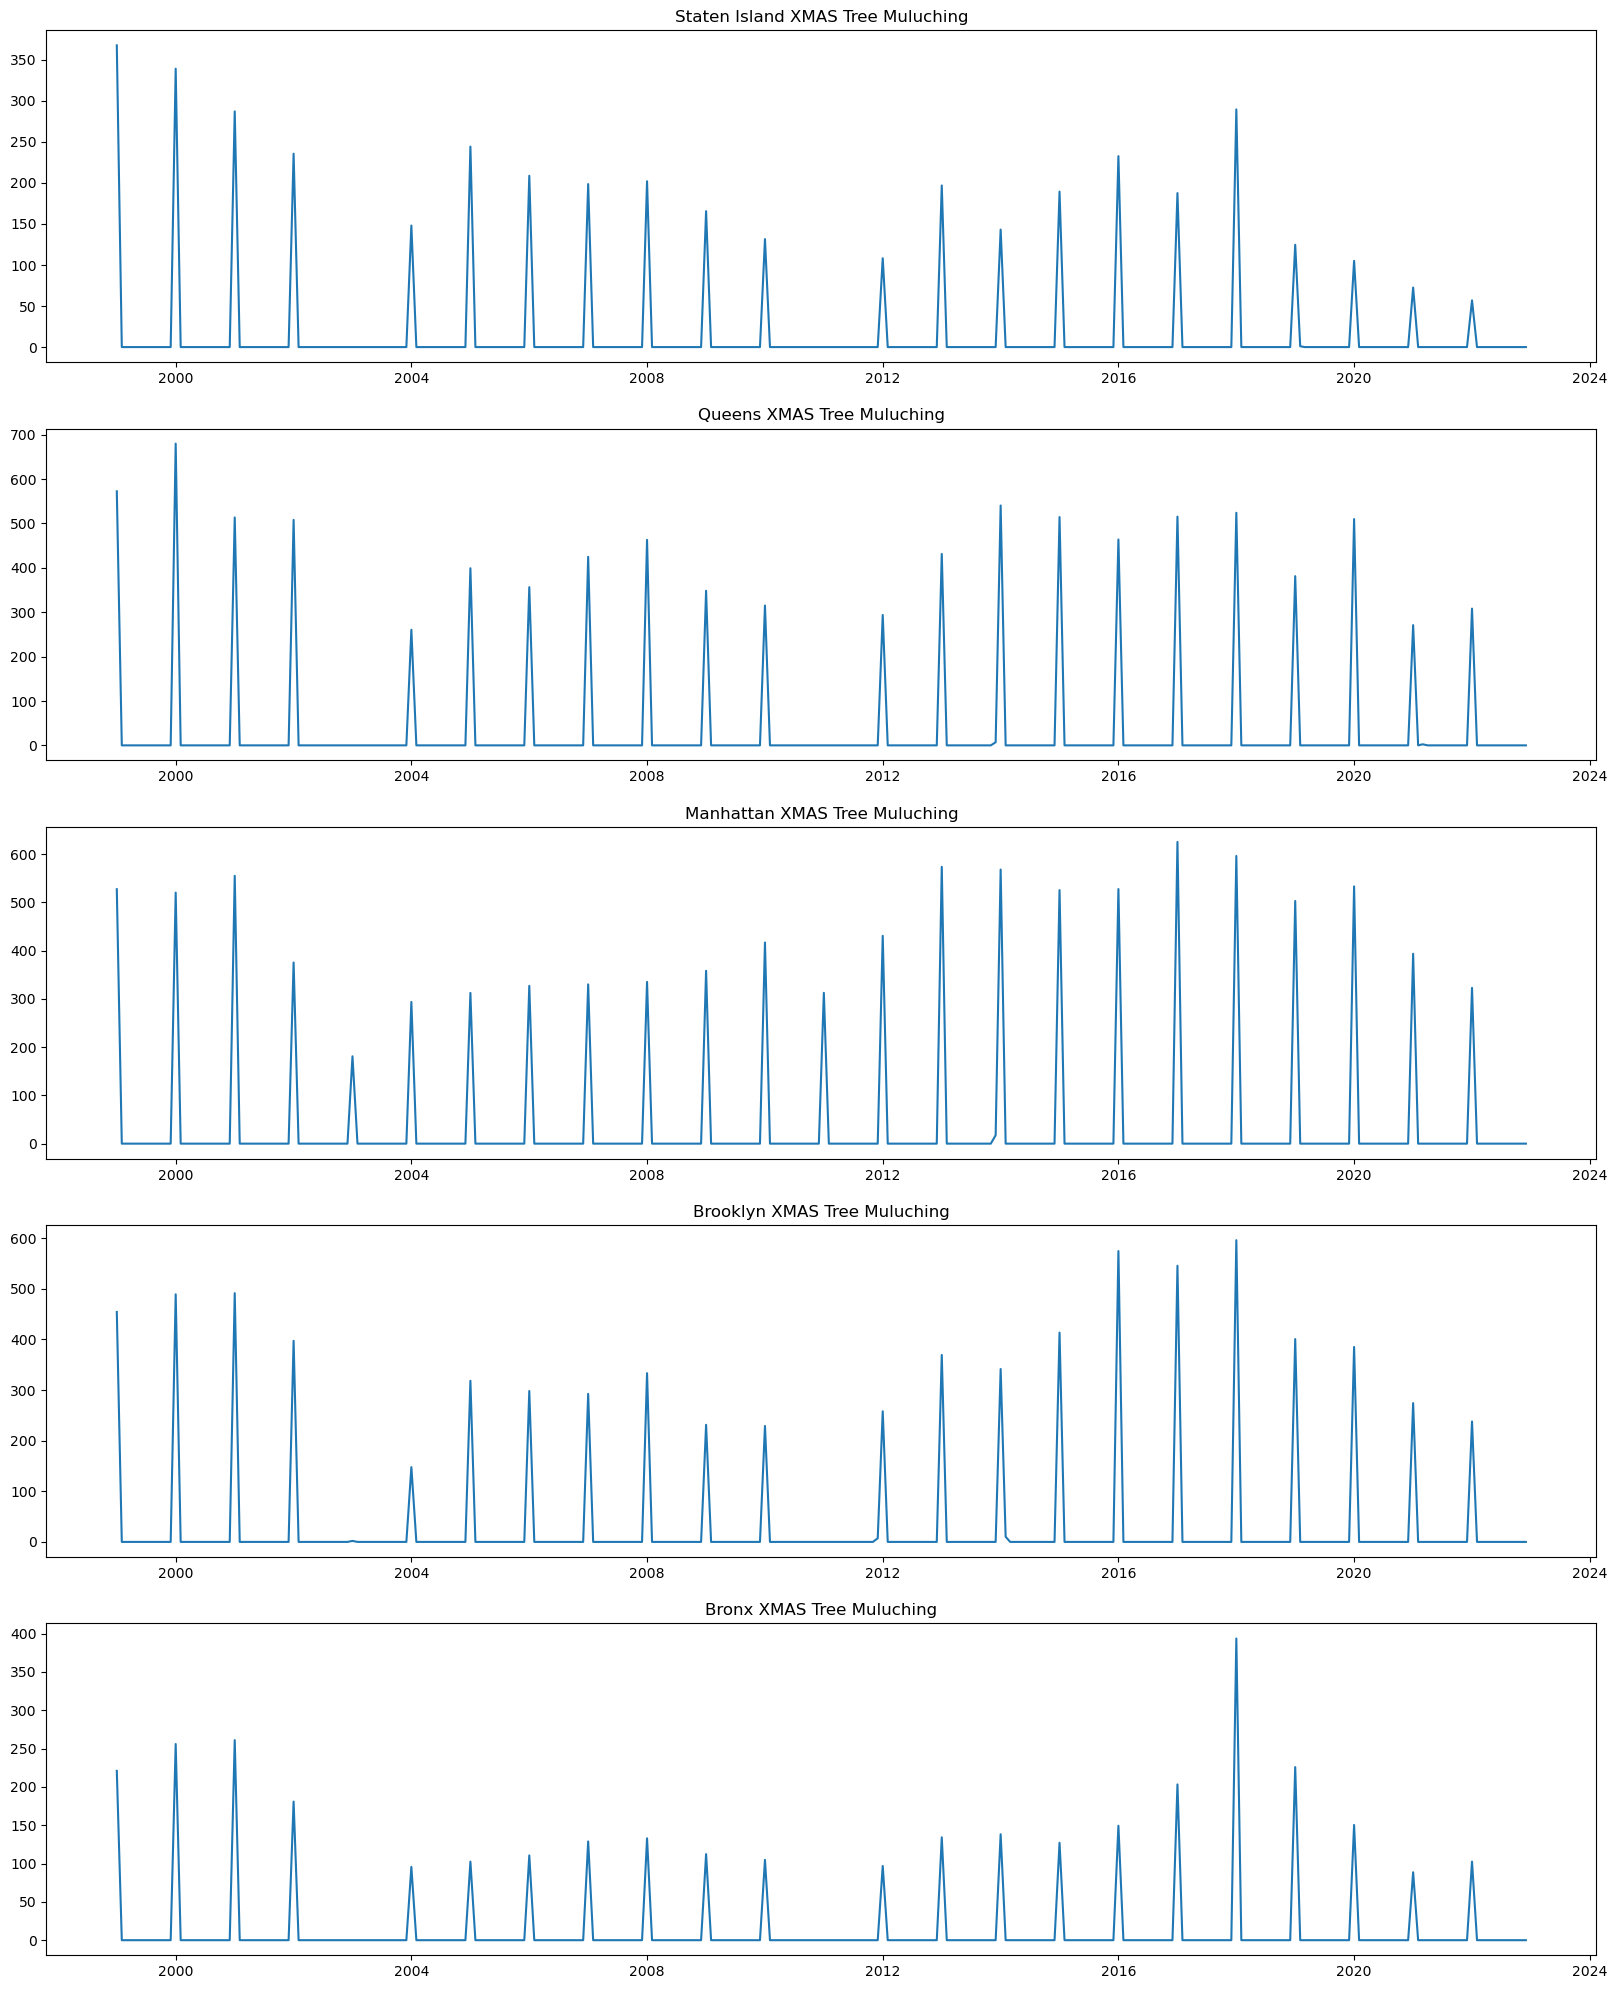

In [321]:
'''fig, axes = plt.subplots(5,1, figsize =(20,25))

january = ['1999-01-01','2000-01-01','2001-01-01','2002-01-01','2003-01-01','2004-01-01','2005-01-01','2006-01-01','2007-01-01','2008-01-01','2009-01-01','2010-01-01','2011-01-01','2012-01-01','2013-01-01','2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01','2020-01-01','2021-01-01','2022-01-01','2023-01-01']

axes[0].plot(df_Staten_Island_Sum['Date'],df_Staten_Island_Sum['XMAS_Trees_2_Muluch'])
axes[0].set_title('Staten Island XMAS Tree Muluching')

#axes[0].set_xticks(january)

axes[1].plot(df_Queens_Sum['Date'],df_Queens_Sum['XMAS_Trees_2_Muluch'])
axes[1].set_title('Queens XMAS Tree Muluching')

axes[2].plot(df_Manhattan_Sum['Date'],df_Manhattan_Sum['XMAS_Trees_2_Muluch'])
axes[2].set_title('Manhattan XMAS Tree Muluching')

axes[3].plot(df_Brooklyn_Sum['Date'],df_Brooklyn_Sum['XMAS_Trees_2_Muluch'])
axes[3].set_title('Brooklyn XMAS Tree Muluching')

axes[4].plot(df_Bronx_Sum['Date'],df_Bronx_Sum['XMAS_Trees_2_Muluch'])
axes[4].set_title('Bronx XMAS Tree Muluching')'''



In summary. I think I found that Garbage is trending slightly down, paper recycing is staying largly the same, and mixed recycling is increasing. I also think I found that garbage increases in warm/nice weather and generally decreases during colder months, with a small bump up around the holidays. New York also recycles alot of trees for muluch in the various parks. 

I wish I had more time to figure out a way to index better so I could do a trendline and really get into the nitty gritty of if things are increasing/ decreasing.  I suspect I could have done something like len(y_axis) for my x axis in to the linear regression model. I can attest that datetime does not work for linear regression. I also wish I had plotted more years to further illistrate that warmer weather causes a surge in garbage, but it seems like the trend is reversed for recycling. I also wish I had a way to get a total count of human activity instead of relying on population, becuase New York has a significant torist and commuter population.  oh I also tried a correlation plot of the remaining columns and almost none of it correlates. so no one column could be used to predict another columns value everything was below an r of 0.5 it would hav been interesting if something had coorelated though!